# Chapter 10 - Working with unlabled data: clustering analysis

*Unsupervised learning*: techniques of finding patters in data that is unlabeled.

*Clustering*: an unsupervised learning technique that finds groups of data that are similar.

Other important points:
- *K-means* to find centers of similarities in data
- Bottom-up approach of clustering using hierachical clustering tress
- Finding arbitrary shapes in data using density based clustering

## Grouping objects by similarity using k-means

### k-means clustering using scikit-learn

K-means is a *prototype-based clustering* algorithm, meaning that each cluster is represented by a prototype; this prototype is typically defined as the *centroid* (the average of a continuous feature) or the *medoid* (the most representative categorical point which minimizes distances to all other points). Note that the number of clusters is a hyperparameter which needs to be decided by some metric evlatuation. 

K-means is summarized in the following steps:
1. Pick $k$ random centroids
2. ASsign each example to the nearest centroid, $\mu^{(j)}, j \in {1, \dots , k}$
3. Move the centroid to the center of the examples that were assigned to it
4. Repeat steps 2 and 3 until centroids no longer move or a maximum number of iterations is reached

Generally the measure of similarity is the squared eclidean distance between points:
$$
    d(x, y)^2 = \sum_{j = 1}^m (x_j - y_j)^2 = \|x - y\|^2_ 2
$$
for the $j$th dimension o the example inputs. Based on this the k-means can be understood as an optimization probem for the sum of square errors (a.k.a. the cluster intertia):
$$
    SSE = \sum_{i=1} ^n \sum_{j=1}^k w^{(i, j)} \|x^{(i)} - \mu^{(j)}\|^2_2
$$
where $\mu^{(j)}$ is a representative point for cluster $j$ and 
$$
    w^{(i, j)} = \begin{cases}
                    1 & \text{if } x^{(i)} \in j \\
                    0 & \text{otherwise}
                 \end{cases}
$$

To illustrate, create a dataset with clusters:

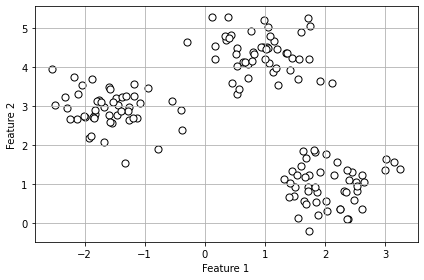

In [1]:
from sklearn.datasets import make_blobs 
X, y = make_blobs(n_samples=150,
    n_features=2,
    centers=3,
    cluster_std=0.5,
    shuffle=True,
    random_state=0) 
import matplotlib.pyplot as plt 
plt.scatter(X[:, 0],
    X[:, 1],
    c='white',
    marker='o',
    edgecolor='black',
    s=50)
plt.xlabel('Feature 1') 
plt.ylabel('Feature 2') 
plt.grid()
plt.tight_layout()
plt.show()

Now apply the `KMeans` from scikit-learn:

In [2]:
from sklearn.cluster import KMeans 
km = KMeans(n_clusters=3,
    init='random',
    n_init=10, #run the algorithm 10 times with different initial centroids
    max_iter=300, #will stop if it converges before this point
    tol=1e-04,
    random_state=0) 
y_km = km.fit_predict(X)

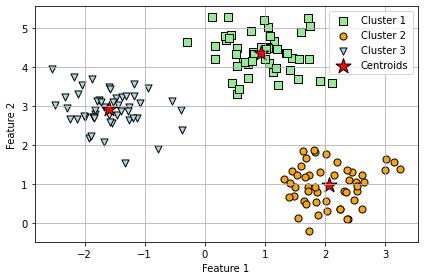

In [3]:
plt.scatter(X[y_km == 0, 0],
    X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='Cluster 1') 
plt.scatter(X[y_km == 1, 0],
    X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='Cluster 2') 
plt.scatter(X[y_km == 2, 0],
    X[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='Cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='Centroids') 
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(scatterpoints=1) 
plt.grid()
plt.tight_layout()
plt.show()

It works well; but the drawback is having to decide on $k$. 

### A smarter way of placing the initial cluster centroids using k-means++

The *k-means++* algorithm places the initial centroids as far away from each other, which to better and more consistent results.  The algorithm can be summarized in the following steps:
1. Initialize $M$, and empty set to store $k$ centroids
2. Randomly choose the first centroid, $\mu^{(j)}$, from input examples and assign it to $M$
3. For every example, $x^{(i)}$, not in $M$, find the minimum square distance, $d(x^{(i)}, M)^2$, to and of the centroid in $M$.
4. To assign the next centroid, $\mu^{(p)}$, use a weighted probability distibution equal to
$$
    \frac{d(\mu^{(p)}, M)^2}{\sum_i d(x^{(i)}, M)^2}
$$
5. Repeat steps 3 and 4 until $k$ centroids are chosen
6. Proceed with the basic k-means algorithm

To use the algorithm with `KMeans`, use `init='k-means++'`.

### Hard versus soft clustering

*Hard clustering* assigns every example in a dataset to a single cluster; *soft clustering* or *fuzzy clustering* assigns examples to one or more clusters. An example of soft clustering is *fuzzy C-means* (FCM), which is similar to k-means clustering.  In fuzzy C-means probabilities are assigned to each example.  The algorithm can be summarized as follows:
1. Specify $k$ centroids and randomly assign examples to clsuters
2. Compute centroids, $\mu^{(j)}$ where $j \leq k$.
3. Update cluster membership
4. Repeat 2 and 3 for $n$ interations or until convergence

Then the cluster membership vector can be represented as
$$
    \left[ \begin{matrix}
            x \in \mu^{(1)} \to w^{(i, j)} = 0.1 \\
            x \in \mu^{(2)} \to w^{(i, j)} = 0.85 \\
            x \in \mu^{(3)} \to w^{(i, j)} = 0.05
        \end{matrix}\right]
$$

The objective function can be defined as
$$
    J_m = \sum_{i=1}^n \sum_{j=1}^k w^{(i, j)^m} \|x^{(i)} - \mu^{(j)}\|^2_2
$$
where the exponent, $m \geq 1$, is the *fuzziness coefficient* with a typical value of 2. The larger value of $m$ leads to fuzzier clsuters:
$$
    w^{(i, j)} = \left[\sum_{c=1}^k \frac{\|x^{(i)} - \mu^{(j)}\|_2}{\|x^{(i)} - \mu^{(c)}\|_2}^{\frac{2}{m-1}}\right]^{-1}
$$
and the centroid is a weighted mean:
$$
    \mu^{j} = \frac{\sum_{i=1}^n w^{(i, j)^m} x^{(i)}
                    }{
                    \sum_{i=1}^n w^{(i, j)^m}
                    }
$$

### Using the elbow method to find the optimal number of clusters

Because there are an unknown number of clusters, we need to use intrinsic metric to determine the most efficient number of clusters; for example, within cluster SSE. The scikit-learn has `interia_` attribute.

In [4]:
print(f'Distortion: {km.inertia_:.2f}')

Distortion: 72.48


As can be seen from the elbow plot below, the most efficient number of clusters is 3.

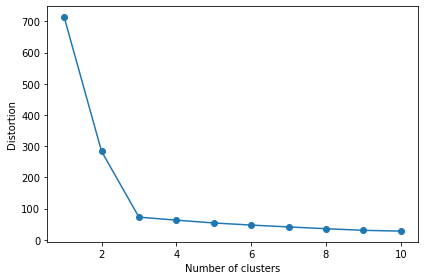

In [6]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init = 10,
                max_iter = 300,
                random_state = 0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions, marker='o') 
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

### Quantifying the quality of clustering via silouette plots

*Silouette analysis* is a visual representation of how tightly grouped a cluster is. It uses the *silhouette coefficient* which is calculated as follows:
1. Calculate *cluster cohesion*, $a^{(i)}$, as the average distance between an example and all other cluster members
2. Calculate *cluster seperation*, $b^{(i)}$, as the average distance between an example and the examples in the nearest clsuter (how is nearness determined? by the nearest centroid?)
3. Calculate the silhouette coefficient as 
$$
    s^{(i)} = \frac{b^{(i)} - a^{(i)}}{\text{max}\{b^{(i)}, a^{(i)}\}}
$$
The closer to 1 $s$ is and if $b^{(i)} >> a^{(i)}$, the clusters are more different.

`silhouette_scores` can be used from scikit-learn's `metric` module.

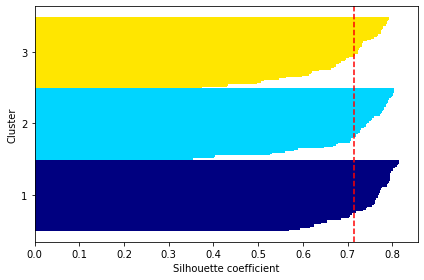

In [7]:
km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0) 
y_km = km.fit_predict(X)
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples 
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(
    X, y_km, metric='euclidean'
    )
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()

    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
         c_silhouette_vals,
         height=1.0,
         edgecolor='none',
         color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals) 
plt.axvline(silhouette_avg,
    color="red",
    linestyle="--")
plt.yticks(yticks, cluster_labels + 1) 
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient') 
plt.tight_layout()
plt.show()

Note that the silhouette scores are far from zero and about equally far from the average silhouette score.  This indicates good clustering. 

## Organizing clusters as a hierachical tree